# Explore Article Data to Check Quality

Make sure to explore the scRNA-seq data before doing any preprocessing modeling to see if the mutation that we are looking at here can actually explain any of the variance in the output data.

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

In [2]:
cell_meta = pd.read_csv(
    "../../resources/GSE158067/GSE158067_cell_to_perturbation.tsv",
    sep="\t",
    index_col=0,
)
cell_meta

,Perturbation
RNA_cell_ID,
CH02_EC_A10_S34,MT
CH02_EC_A12_S36,NG
CH02_EC_A2_S26,MT
CH02_EC_A3_S27,MT
CH02_EC_A4_S28,NG
...,...
CH04.3.cDNA.H5_S289,WT
CH04.3.cDNA.H6_S290,MT
CH04.3.cDNA.H7_S291,WT


In [3]:
expr = pd.read_csv(
    "../../resources/GSE158067/GSE158067_gene_exp_mtx.txt", sep="\t", index_col=0
)
expr = expr.loc[:, cell_meta.index]  # type: ignore
expr

RNA_cell_ID,CH02_EC_A10_S34,CH02_EC_A12_S36,CH02_EC_A2_S26,CH02_EC_A3_S27,CH02_EC_A4_S28,CH02_EC_A5_S29,CH02_EC_A6_S30,CH02_EC_A7_S31,CH02_EC_A8_S32,CH02_EC_A9_S33,...,CH04.3.cDNA.H12_S296,CH04.3.cDNA.H1_S285,CH04.3.cDNA.H2_S286,CH04.3.cDNA.H3_S287,CH04.3.cDNA.H4_S288,CH04.3.cDNA.H5_S289,CH04.3.cDNA.H6_S290,CH04.3.cDNA.H7_S291,CH04.3.cDNA.H8_S292,CH04.3.cDNA.H9_S293
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F29,2,3,0,3,0,0,9,4,1,0,...,0,0,0,0,0,0,0,0,0,0
OR4F16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4,12978,5077,5632,9842,8432,2586,8901,9382,13618,5384,...,5056,3403,4492,4588,1676,3413,4729,8041,3356,5452
MT-ND5,5584,1403,1233,791,1197,1362,2417,2248,2080,1309,...,1680,1381,1087,1343,933,1917,2183,2498,2125,1731
MT-ND6,237,0,46,187,76,137,140,159,59,0,...,284,119,87,246,147,234,465,225,287,117
MT-CYB,12532,2782,3100,7376,5319,1796,6687,6578,7146,1986,...,3820,2530,4654,3590,1002,2712,3019,6890,2564,3836


# Comprehensive scRNA-seq Preprocessing Pipeline

This pipeline includes all standard preprocessing steps for scRNA-seq data:
1. **Quality Control Metrics** - Calculate QC metrics (genes per cell, UMI counts, mitochondrial gene percentage)
2. **Cell and Gene Filtering** - Remove low-quality cells and rarely expressed genes
3. **Normalization** - Library size normalization and log transformation
4. **Feature Selection** - Identify highly variable genes
5. **Scaling** - Z-score normalization for downstream analysis
6. **Dimensionality Reduction** - PCA for visualization and further analysis

In [4]:
# Create AnnData object for scanpy processing
# Transpose the matrix so cells are rows and genes are columns (scanpy convention)
adata = ad.AnnData(X=expr.T)
adata.var_names = expr.index  # Gene names
adata.obs_names = expr.columns  # Cell names

# Calculate quality control metrics
adata.obs["perturbation"] = cell_meta["Perturbation"]
adata.obs["genotype"] = cell_meta["Perturbation"].map(
    {"MT": "Mutant", "WT": "Wild-type", "NG": "Not-genotyped"}
)

print(f"Data shape: {adata.shape[0]} cells × {adata.shape[1]} genes")
print(f"Genotype distribution:\n{adata.obs['genotype'].value_counts()}")
adata

Data shape: 528 cells × 22032 genes
Genotype distribution:
genotype
Mutant           240
Wild-type        201
Not-genotyped     87
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 528 × 22032
    obs: 'perturbation', 'genotype'

## Step 1: Quality Control Metrics

In [5]:
# Calculate QC metrics
# Mitochondrial genes (MT- prefix)
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# Ribosomal genes (RP[SL] prefix)
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# Hemoglobin genes (HB prefix)
adata.var["hb"] = adata.var_names.str.startswith("HB")

# Calculate basic QC metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# Manually calculate percentage of mitochondrial and ribosomal genes
adata.obs["pct_counts_mt"] = (
    np.array(adata[:, adata.var["mt"]].X.sum(axis=1)).flatten()
    / adata.obs["total_counts"]
    * 100
)
adata.obs["pct_counts_ribo"] = (
    np.array(adata[:, adata.var["ribo"]].X.sum(axis=1)).flatten()
    / adata.obs["total_counts"]
    * 100
)

# Additional QC metrics
adata.obs["n_genes_by_counts"] = adata.obs["n_genes_by_counts"].astype(int)
adata.obs["total_counts"] = adata.obs["total_counts"].astype(int)

print("QC metrics calculated:")
print(
    f"- Total counts per cell: {adata.obs['total_counts'].min():.0f} - {adata.obs['total_counts'].max():.0f}"
)
print(
    f"- Genes per cell: {adata.obs['n_genes_by_counts'].min()} - {adata.obs['n_genes_by_counts'].max()}"
)
print(f"- Mitochondrial genes: {adata.var['mt'].sum()}")
print(f"- Ribosomal genes: {adata.var['ribo'].sum()}")
print(f"- Hemoglobin genes: {adata.var['hb'].sum()}")

adata.obs[
    ["total_counts", "n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo"]
].head()

QC metrics calculated:
- Total counts per cell: 1085 - 1710649
- Genes per cell: 420 - 16054
- Mitochondrial genes: 13
- Ribosomal genes: 101
- Hemoglobin genes: 10


,total_counts,n_genes_by_counts,pct_counts_mt,pct_counts_ribo
RNA_cell_ID,,,,
CH02_EC_A10_S34,887868,4265,17.178117,40.434502
CH02_EC_A12_S36,362491,2590,11.259038,21.168250
CH02_EC_A2_S26,758769,4241,4.475670,32.569596
CH02_EC_A3_S27,837047,3825,7.897884,32.365686
CH02_EC_A4_S28,938406,3844,6.578602,30.265471


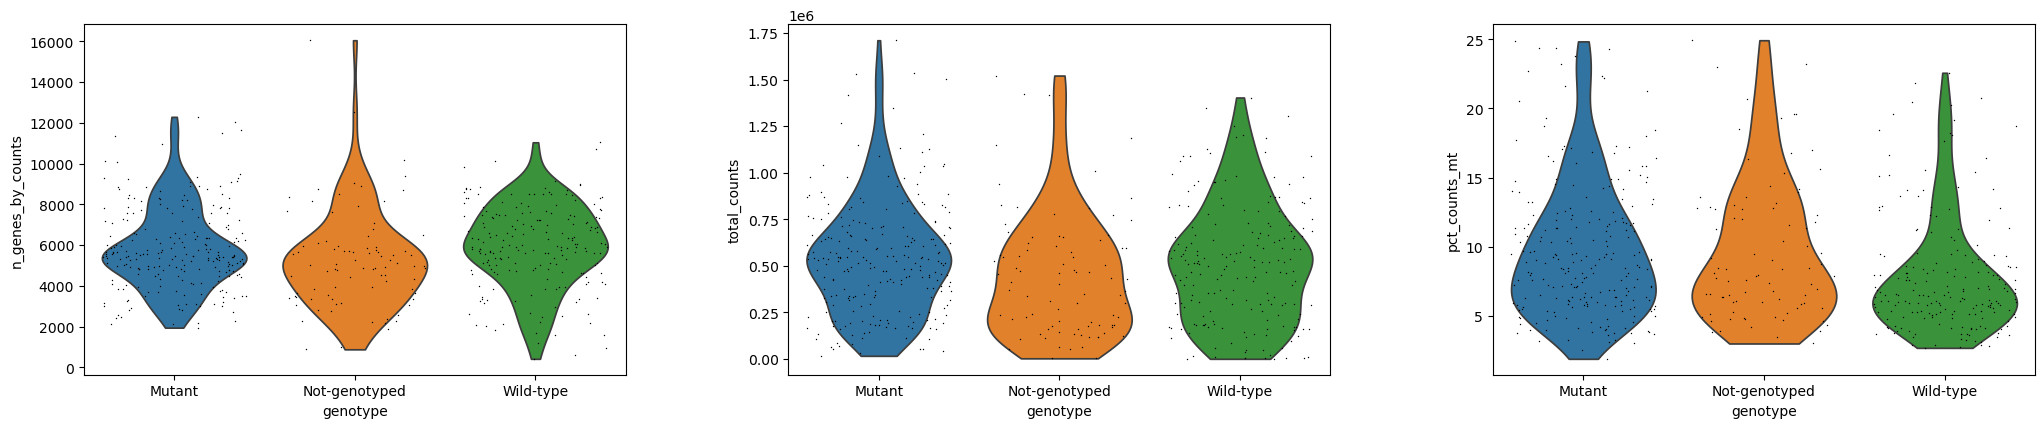

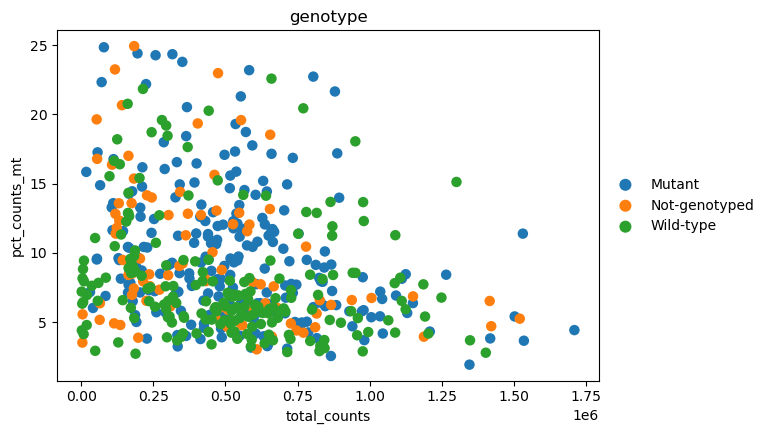

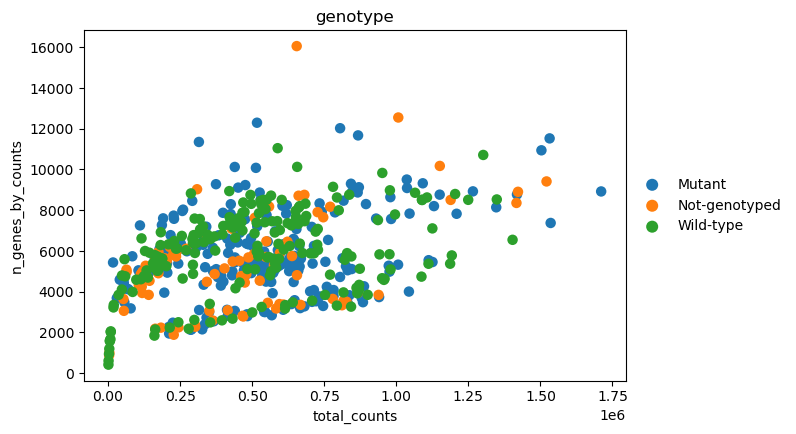

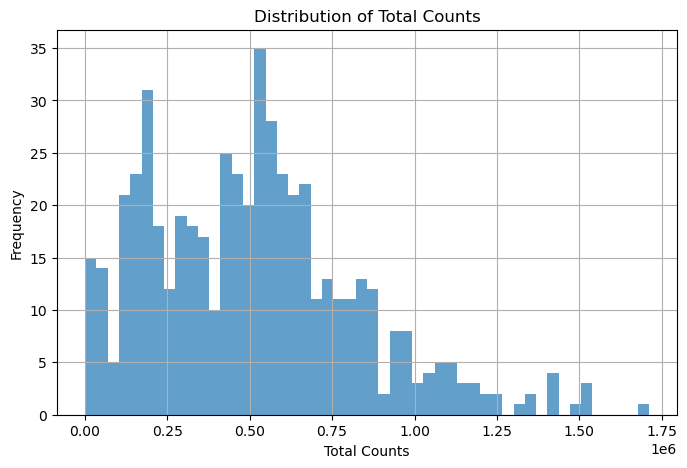

In [6]:
# Visualize QC metrics
# Violin plots for QC metrics by genotype
ax = sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    groupby="genotype",
    #    title="QC Metrics by Genotype",
)

# Scatter plot - Total Counts vs Mitochondrial %
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", color="genotype")

# Scatter plot - Total Counts vs Number of Genes
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="genotype")

# Distribution of total counts
plt.figure(figsize=(8, 5))
adata.obs["total_counts"].hist(bins=50, alpha=0.7)
plt.xlabel("Total Counts")
plt.ylabel("Frequency")
plt.title("Distribution of Total Counts")
plt.show()

## Step 2: Cell and Gene Filtering

In [8]:
# Save raw data
adata.raw = adata

# Set filtering thresholds based on data distribution
min_genes = 200  # Minimum number of genes expressed in a cell
min_cells = 3  # Minimum number of cells expressing a gene
max_genes = 5000  # Maximum number of genes (potential doublets)
max_mt_pct = 20  # Maximum mitochondrial gene percentage

print(f"Before filtering: {adata.shape[0]} cells by {adata.shape[1]} genes")

# Filter cells
#  sc.pp.filter_cells(adata, min_genes=min_genes)
print(f"After min_genes filter: {adata.shape[0]} cells by {adata.shape[1]} genes")

# Filter genes
#  sc.pp.filter_genes(adata, min_cells=min_cells)
print(f"After min_cells filter: {adata.shape[0]} cells by {adata.shape[1]} genes")

# Filter cells with too many genes (potential doublets)
#  adata = adata[adata.obs.n_genes_by_counts < max_genes, :]
print(f"After max_genes filter: {adata.shape[0]} cells by {adata.shape[1]} genes")

# Filter cells with high mitochondrial percentage
#  adata = adata[adata.obs.pct_counts_mt < max_mt_pct, :]
print(f"After mitochondrial filter: {adata.shape[0]} cells by {adata.shape[1]} genes")

# Check genotype distribution after filtering
print(f"\nGenotype distribution after filtering:")
print(adata.obs["genotype"].value_counts())

Before filtering: 528 cells by 22032 genes
After min_genes filter: 528 cells by 22032 genes
After min_cells filter: 528 cells by 22032 genes
After max_genes filter: 528 cells by 22032 genes
After mitochondrial filter: 528 cells by 22032 genes

Genotype distribution after filtering:
genotype
Mutant           240
Wild-type        201
Not-genotyped     87
Name: count, dtype: int64


## Step 3: Normalization and Log Transformation

Normalization completed:
- Library size normalized to 10,000 reads per cell
- Log(x+1) transformation applied
- Data range: 0.00 to 3.92


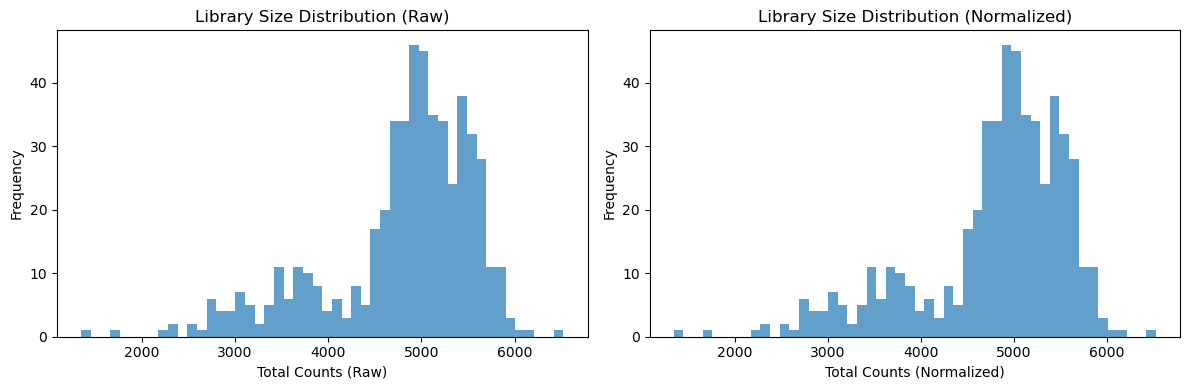

In [9]:
# Normalize to 10,000 reads per cell (CPM-like normalization)
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transform (log(x + 1))
sc.pp.log1p(adata)

# Save normalized data
adata.layers["normalized"] = adata.X.copy()

print("Normalization completed:")
print(f"- Library size normalized to 10,000 reads per cell")
print(f"- Log(x+1) transformation applied")
print(f"- Data range: {adata.X.min():.2f} to {adata.X.max():.2f}")

# Plot distribution before and after normalization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Raw data distribution (from raw.X)
axes[0].hist(np.array(adata.raw.X.sum(axis=1)).flatten(), bins=50, alpha=0.7)
axes[0].set_xlabel("Total Counts (Raw)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Library Size Distribution (Raw)")

# Normalized data distribution
axes[1].hist(np.array(adata.X.sum(axis=1)).flatten(), bins=50, alpha=0.7)
axes[1].set_xlabel("Total Counts (Normalized)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Library Size Distribution (Normalized)")

plt.tight_layout()
plt.show()

## Step 4: Highly Variable Gene Selection

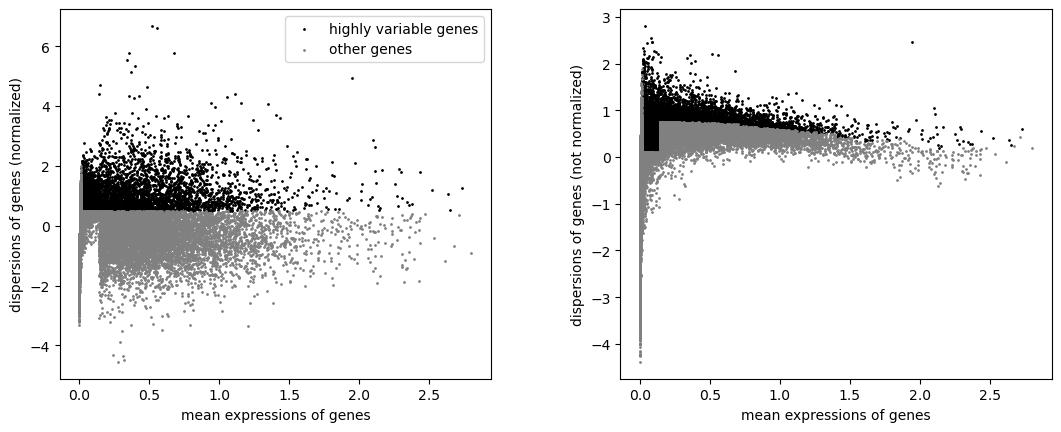

Number of highly variable genes: 5931
Total genes: 22032
Percentage of highly variable genes: 26.9%

Top 10 highly variable genes:
             means  dispersions  dispersions_norm
S100A9    0.517030     2.209113          6.680044
S100A8    0.555182     2.191382          6.606456
LYZ       0.677201     1.830904          5.771035
VCAN      0.356624     2.180617          5.762100
SERPINA1  0.337884     2.116306          5.526895
FCN1      0.396172     2.062086          5.328598
HDC       0.367448     2.012384          5.146823
DNMT3A    1.946636     2.453995          4.940599
CEACAM19  0.148090     2.129976          4.704274
FCER1A    0.481156     1.714240          4.626191


In [10]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot highly variable genes
sc.pl.highly_variable_genes(adata)

print(f"Number of highly variable genes: {adata.var['highly_variable'].sum()}")
print(f"Total genes: {adata.shape[1]}")
print(
    f"Percentage of highly variable genes: {adata.var['highly_variable'].sum() / adata.shape[1] * 100:.1f}%"
)

# Show top highly variable genes
hvg_df = adata.var[adata.var["highly_variable"]].sort_values(
    "dispersions_norm", ascending=False
)
print("\nTop 10 highly variable genes:")
print(hvg_df[["means", "dispersions", "dispersions_norm"]].head(10))

## Step 5: Scaling and Centering

Scaling completed:
- Data centered to zero mean
- Scaled to unit variance
- Extreme values clipped to [-10, 10]
- Data range: -8.88 to 10.00


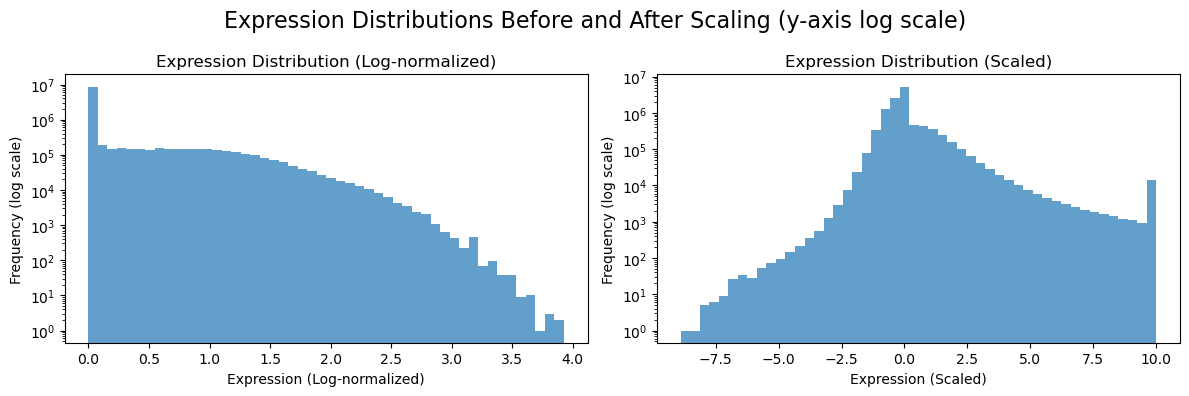

In [11]:
# Save normalized data before scaling
adata.layers["log_normalized"] = adata.X.copy()

# Scale data
sc.pp.scale(adata, max_value=10)  # Clip values to [-10, 10] to avoid extreme outliers

print("Scaling completed:")
print(f"- Data centered to zero mean")
print(f"- Scaled to unit variance")
print(f"- Extreme values clipped to [-10, 10]")
print(f"- Data range: {adata.X.min():.2f} to {adata.X.max():.2f}")

# Plot distribution before and after scaling
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Log-normalized data distribution
log_norm_data = (
    adata.layers["log_normalized"].toarray()
    if hasattr(adata.layers["log_normalized"], "toarray")
    else adata.layers["log_normalized"]
)
axes[0].hist(log_norm_data.flatten(), bins=50, alpha=0.7, log=True)
axes[0].set_xlabel("Expression (Log-normalized)")
axes[0].set_ylabel("Frequency (log scale)")
axes[0].set_title("Expression Distribution (Log-normalized)")

# Scaled data distribution
scaled_data = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
axes[1].hist(scaled_data.flatten(), bins=50, alpha=0.7, log=True)
axes[1].set_xlabel("Expression (Scaled)")
axes[1].set_ylabel("Frequency (log scale)")
axes[1].set_title("Expression Distribution (Scaled)")

fig.suptitle(
    "Expression Distributions Before and After Scaling (y-axis log scale)", fontsize=16
)

plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'Expression Distributions Before and After Scaling')

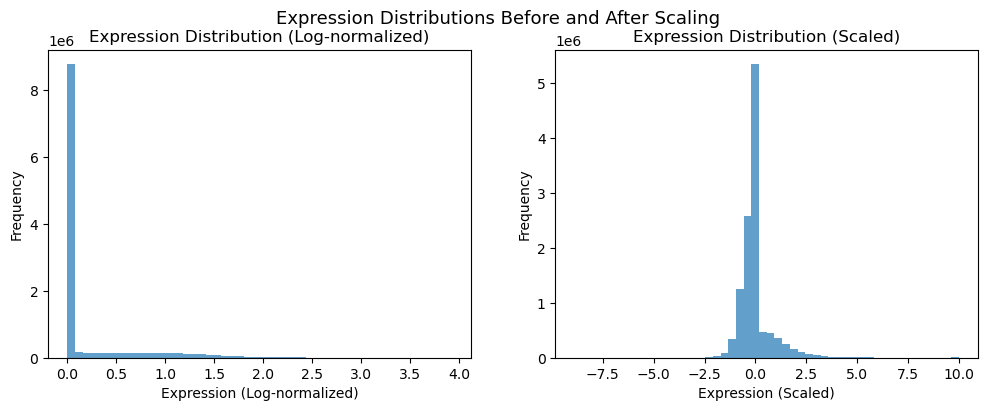

In [12]:
# Plot distribution before and after scaling
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Log-normalized data distribution
log_norm_data = (
    adata.layers["log_normalized"].toarray()
    if hasattr(adata.layers["log_normalized"], "toarray")
    else adata.layers["log_normalized"]
)

axes[0].hist(log_norm_data.flatten(), bins=50, alpha=0.7)
axes[0].set_xlabel("Expression (Log-normalized)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Expression Distribution (Log-normalized)")

# Scaled data distribution (linear scale)
axes[1].hist(scaled_data.flatten(), bins=50, alpha=0.7)
axes[1].set_xlabel("Expression (Scaled)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Expression Distribution (Scaled)")

fig.suptitle("Expression Distributions Before and After Scaling", fontsize=13)

## Step 6: Principal Component Analysis

Removed 102 outlier cells for cleaner PCA visualization
Plotting 426 cells out of 528 total cells

=== Original PCA plots (with outliers) ===


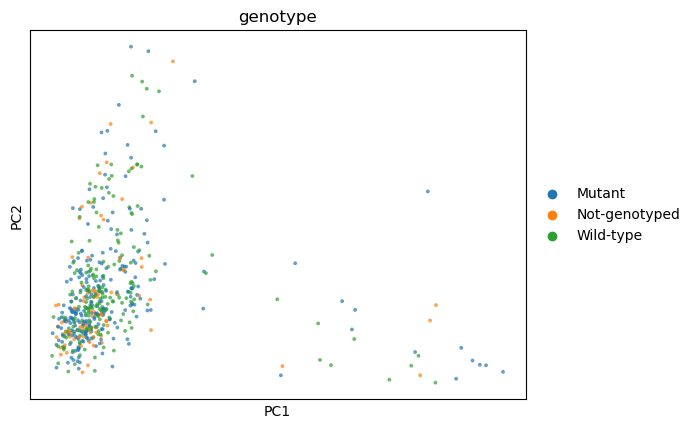

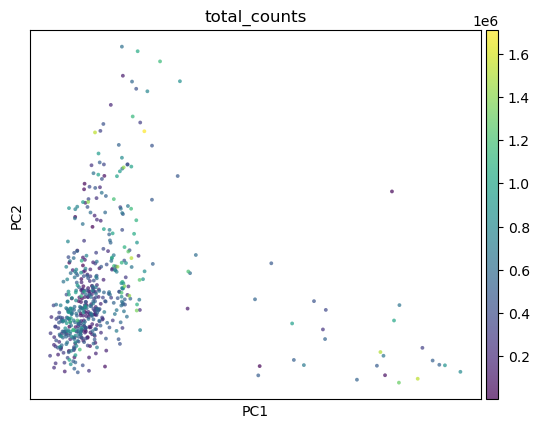

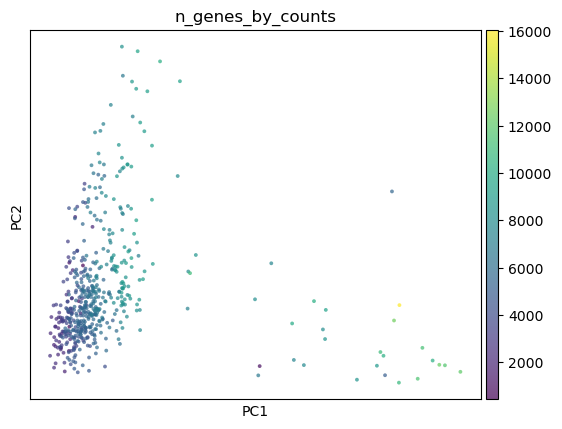


=== Cleaned PCA plots (outliers removed) ===


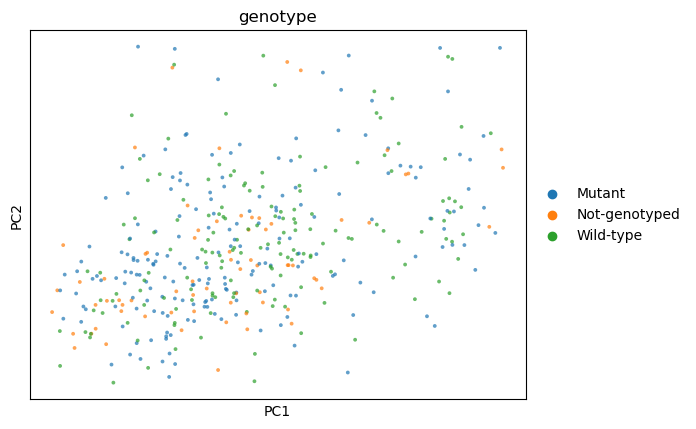

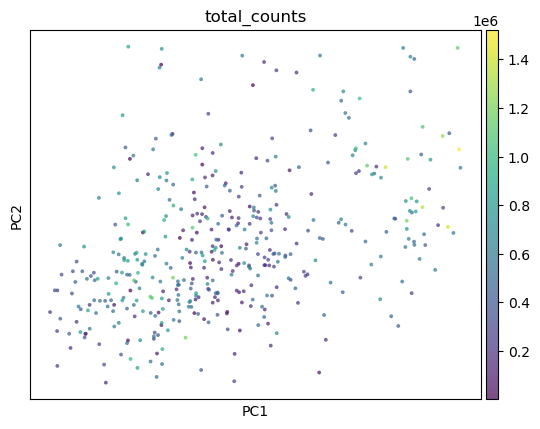

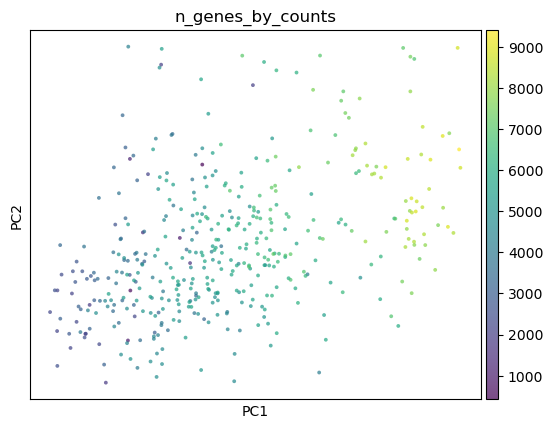

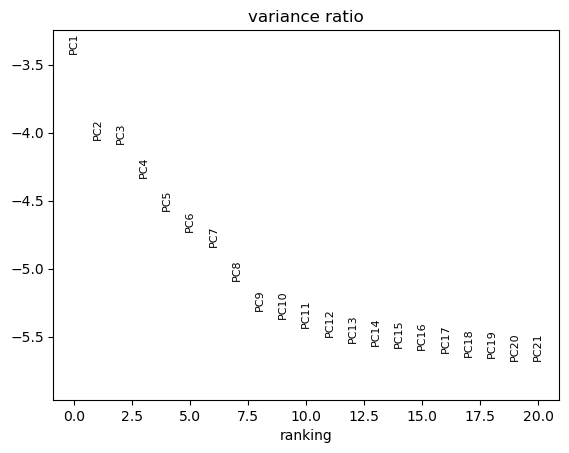

Variance explained by first 10 PCs: 12.29%
Variance explained by first 20 PCs: 16.06%


In [15]:
# Perform PCA
sc.tl.pca(adata, svd_solver="arpack", n_comps=50)

# Remove outliers for cleaner PCA visualization
# Identify cells that are extreme outliers in PC1 and PC2 space
pc1_coords = adata.obsm["X_pca"][:, 0]
pc2_coords = adata.obsm["X_pca"][:, 1]

# Calculate percentiles for outlier detection
pc1_lower, pc1_upper = np.percentile(pc1_coords, [1, 90])
pc2_lower, pc2_upper = np.percentile(pc2_coords, [1, 90])

# Identify non-outlier cells (within 1st-90th percentile range)
non_outlier_mask = (
    (pc1_coords >= pc1_lower)
    & (pc1_coords <= pc1_upper)
    & (pc2_coords >= pc2_lower)
    & (pc2_coords <= pc2_upper)
)

# Create a temporary dataset without outliers for plotting
adata_plot = adata[non_outlier_mask].copy()

print(
    f"Removed {(~non_outlier_mask).sum()} outlier cells for cleaner PCA visualization"
)
print(f"Plotting {adata_plot.shape[0]} cells out of {adata.shape[0]} total cells")

# Plot original PCA results (with outliers)
print("\n=== Original PCA plots (with outliers) ===")
# PCA plot colored by genotype - original
sc.pl.pca(adata, color="genotype", size=30, alpha=0.7)

# PCA plot colored by total counts - original
sc.pl.pca(adata, color="total_counts", size=30, alpha=0.7)

# PCA plot colored by number of genes - original
sc.pl.pca(adata, color="n_genes_by_counts", size=30, alpha=0.7)

# Plot cleaned PCA results (without outliers)
print("\n=== Cleaned PCA plots (outliers removed) ===")
# PCA plot colored by genotype - cleaned
sc.pl.pca(adata_plot, color="genotype", size=30, alpha=0.7)

# PCA plot colored by total counts - cleaned
sc.pl.pca(adata_plot, color="total_counts", size=30, alpha=0.7)

# PCA plot colored by number of genes - cleaned
sc.pl.pca(adata_plot, color="n_genes_by_counts", size=30, alpha=0.7)

# Plot variance explained by each PC (using original data)
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=20)

print(
    f"Variance explained by first 10 PCs: {adata.uns['pca']['variance_ratio'][:10].sum():.2%}"
)
print(
    f"Variance explained by first 20 PCs: {adata.uns['pca']['variance_ratio'][:20].sum():.2%}"
)

## Step 7: Neighborhood Graph and UMAP

/opt/conda/envs/experimenting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


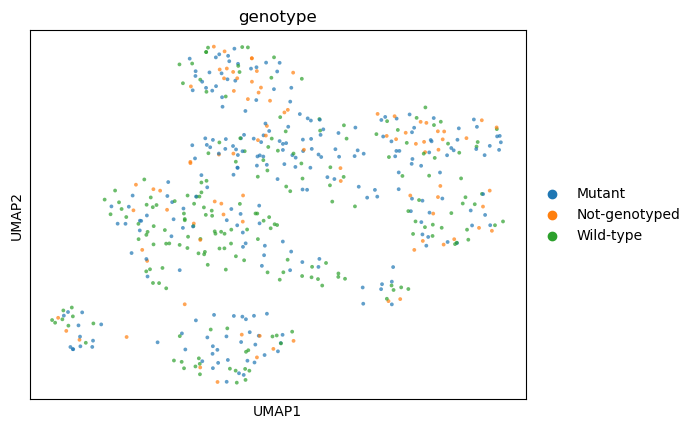

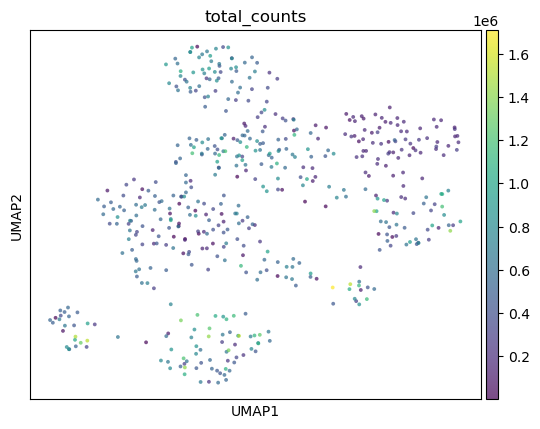

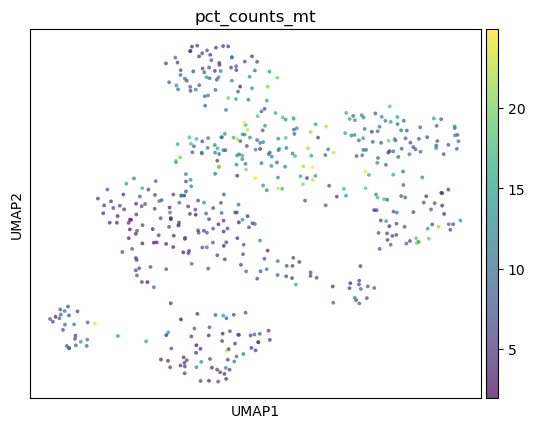

In [14]:
# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Compute UMAP
sc.tl.umap(adata)

# Plot UMAP as separate plots
# UMAP colored by genotype
sc.pl.umap(adata, color="genotype", legend_loc="right margin", size=30, alpha=0.7)

# UMAP colored by total counts
sc.pl.umap(adata, color="total_counts", size=30, alpha=0.7)

# UMAP colored by mitochondrial percentage
sc.pl.umap(adata, color="pct_counts_mt", size=30, alpha=0.7)